In [64]:
import pandas as pd
import tensorflow as tf
import keras
import os.path
import numpy as np

from datetime import datetime

import keras.backend as K
from keras.utils import np_utils
from keras.callbacks import Callback


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from IPython.core.debugger import Pdb

from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# show warnings always
# import warnings
# warnings.filterwarnings('always')

print(tf.VERSION)
print(keras.__version__)

1.9.0
2.2.2


# Read-in data

In [65]:
train_pd = pd.read_csv('./datasets/train.csv', sep=',', header=0)

## Getting to know the data

Check if there is more than 1 household head per household

Group by *idhogar* (household key) and then check column *parentesco1*

In [ ]:
idhogar_aggregated = train_pd.groupby('idhogar').parentesco1.sum()

In [ ]:
idhogar_aggregated[idhogar_aggregated != 1]

There are 15 households with no household head

Check if the poverty label is the same for all members of a household

In [ ]:
target_aggregated = train_pd.groupby('idhogar').Target.aggregate(['min', 'max'])

target_aggregated['poverty_different'] = target_aggregated['min'] != target_aggregated['max']
target_aggregated.loc[target_aggregated['poverty_different']].head(10)

It is not, meaning that members of a given household can have different poverty levels.

In [ ]:
train_pd.loc[train_pd['idhogar'] == '0172ab1d9']

Check if houses that have been fully paid have a montly payment - they should not.

In [ ]:
train_pd.loc[(train_pd['tipovivi1'] == 1) & (~np.isnan(train_pd['v2a1']))] # GOOD

In [ ]:
len(train_pd.columns)

# Prepare data

Drop some unneeded columns

In [66]:
# the columns (SQBage, agesq) and (tamhog, hhsize, hogar_total) are identical - REMOVE THEM
train_pd.drop(columns=['SQBage', 'tamhog', 'hogar_total'], inplace=True)
# drop interaction columns ['edjefe', 'edjefa']
train_pd.drop(columns=['edjefe', 'edjefa', 'SQBedjefe'], inplace=True)
# drop dependency and its square - mixed numerical and alphanumeric values, unclear contribution
train_pd.drop(columns=['dependency', 'SQBdependency'], inplace=True)

# Drop all the squared features
train_pd.drop(columns=['agesq', 'SQBhogar_total', 'SQBhogar_nin', 'SQBovercrowding', 'SQBmeaned'], inplace=True)

len(train_pd.columns)

130

Check the target labels and rebalance if necessary

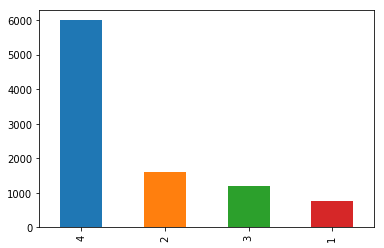

In [5]:
train_pd.Target.value_counts().plot(kind='bar')

In [ ]:
# compute the disbalance
print(train_pd.Target.value_counts())
print(train_pd.Target.value_counts(normalize=True))
print(len(train_pd))

## Train-test split

In [67]:
# Resampling methods

def SMOTE_resample(x, y):
    max_label = pd.Series(y).value_counts().iloc[0]
    sm = SMOTE(random_state=42, ratio={1:max_label, 2:max_label, 3:max_label})
    x_res, y_res = sm.fit_sample(x, y)
    return x_res, y_res

def naive_resample(x, y):
    # simply sample with replacement
    max_label = pd.Series(y).value_counts().iloc[0]
    rus = RandomOverSampler(random_state=42, ratio={1:max_label, 2:max_label, 3:max_label})
    x_res, y_res = rus.fit_sample(x, y)
    return x_res, y_res
    

In [70]:
# prepare the data
# split 

# convert all NaNs to 0 - big assumption
train_pd = train_pd.fillna(0)
#



In [68]:
def CV_monte_carlo(model, N=10, trainining_size=0.8):
    f1_scores = []
    best_model = None
    for n in range(N):
        # split
        input_train, input_test, \
        target_train, target_test = train_test_split(train_pd.loc[:, ~train_pd.columns.isin(['idhogar', 'Id', 'Target'])].values,
                                             train_pd['Target'].values,
                                             test_size=1-trainining_size)
        input_train_rs, target_train_rs = naive_resample(input_train, target_train)
        input_train_smote, target_train_smote = SMOTE_resample(input_train, target_train)
        # fit and evaluate model
        model.fit(input_train_rs, target_train_rs)
        predicted = model.predict(input_test)
        f1 = f1_score(target_test, predicted, average="macro")
        if len(f1_scores) > 0 and f1 > np.max(f1_scores):
            best_model = model
        f1_scores.append(f1)
    
    print("Min/Mean/Max F1-Score = %f / %f / %f "%(np.min(f1_scores), np.mean(f1_scores), np.max(f1_scores)))
    return f1_scores, best_model
        

# Non-DN approaches

## Random Forest

In [53]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=0, warm_start=False)
rf_scores, rf_best = CV_monte_carlo(rf_model)

Min/Mean/Max F1-Score = 0.890409 / 0.903711 / 0.926847 


## AdaBoost

In [62]:
adaboost_model =  AdaBoostClassifier(n_estimators=100)
adaboost_scores, adaboost_best = CV_monte_carlo(adaboost_model)

Min/Mean/Max F1-Score = 0.409123 / 0.444717 / 0.463671 


## Gradient Tree Boosting

In [ ]:
gtb_model = GradientBoostingClassifier(n_estimators=130, learning_rate=2, max_depth=5, random_state=0)
gtb_scores, gtb_best = CV_monte_carlo(gtb_model)

## XGBoost

In [80]:
xgboost_model = XGBClassifier(max_depth=100, n_estimators=100, learning_rate=1, n_jobs=50, booster='gbtree')
xgboost_scores, xgboost_best = CV_monte_carlo(xgboost_model, N=4)

C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Min/Mean/Max F1-Score = 0.904190 / 0.917816 / 0.928624 


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Define the network

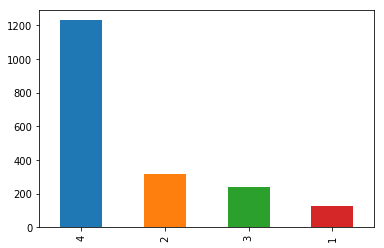

In [8]:
pd.Series(target_test).value_counts().plot(kind='bar')

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.utils import vis_utils

# define custom F1 metric
# taken from https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

class Metrics(Callback):
    def __init__(self):
        self.metric_optimal = 0
    
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        # Pdb().set_trace()
        _val_f1 = f1_score(val_targ, val_predict, average="macro")
        _val_recall = recall_score(val_targ, val_predict, average="macro")
        _val_precision = precision_score(val_targ, val_predict, average="macro")

        if _val_f1 > self.metric_optimal:
            # print(" - Best model found with f1 score = %f. Checkpointing"%_val_f1)
            self.metric_optimal = _val_f1
            self.model.save(self.model.name+'.h5')
            
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        # print(" - val_f1: %f | val_precision: %f | val_recall %f"%(_val_f1, _val_precision, _val_recall))
        return
    
    def on_train_end(self, logs={}):
        print('Best F1-Score for model %s = %f'%(self.model.name, self.metric_optimal))
        
def create_model(model_object, name):
    model_object.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    model_object.name = name
    return model_object

all_models = [
    create_model(Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.1),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.1),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v1'),
    create_model(Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.2),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.2),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v2'),
    create_model(Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.3),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.3),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v3'),
    create_model(Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.4),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.4),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v4'),
    create_model(Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.5),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.5),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v5'),
    create_model(Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.6),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.6),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v6'),
        create_model(Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.7),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.7),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v7'),
        create_model(Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.8),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.8),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v8'),
        create_model(Sequential([
        Dense(units=80, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.6),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.6),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v9')    
]


def instantiate_model(model_name):
    m = Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.4),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.4),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ])
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    m.name = model_name
    return m


In [10]:
for m in all_models:
    print("Running model: %s"%m.name)
    m.fit(input_train_rs, np_utils.to_categorical(target_train_rs-1), 
          validation_data = (input_test, np_utils.to_categorical(target_test-1)),
          epochs = 100, batch_size = 120,verbose = 0, callbacks = [Metrics()])

Running model: model_v1


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best F1-Score for model model_v1 = 0.516681
Running model: model_v2
Best F1-Score for model model_v2 = 0.512790
Running model: model_v3


KeyboardInterrupt: 

In [ ]:
#  val_f1: 0.235240 | val_precision: 0.584472 | val_recall 0.207276 - Rebalancing (SMOTE)
#  val_f1: 0.372892 | val_precision: 0.628871 | val_recall 0.280111 - Rebalancing (rs)